<a href="https://colab.research.google.com/github/mrzResearchArena/Anticancer-Peptides-CNN/blob/master/Codes/ACP-500-164-single-head.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### [1]. Google Drive Initialization:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ls

drive/  sample_data/


In [3]:
cd 'drive/My Drive/ACP-PyFeat'

/content/drive/My Drive/ACP-PyFeat


In [5]:
ls

bit-in-689.npy   blosum-164.npy      bpf-164.npy      model-240.png
bit-in-776.npy   blosum-240.npy      bpf-240.npy      model-500-164.png
bits-164.npy     blosum-500.npy      bpf-500.npy      model-740.png
bits-240.npy     blosum-740.npy      bpf-740.npy      ROC-240.png
bits-500.npy     blosum-in-689.npy   bpf-in-689.npy   ROC-500-164.png
bits-740.npy     blosum-in-776.npy   bpf-in-776.npy   ROC-740.png
bit-val-172.npy  blosum-val-172.npy  bpf-val-172.npy  ROC.png
bit-val-194.npy  blosum-val-194.npy  bpf-val-194.npy


### [2]. Load Deep Learning API (Keras):

In [6]:
# Deep Neural Networks:
import tensorflow as tf; print('We\'re using TF-{}.'.format(tf.__version__))
# import keras; print('We\'re using Keras-{}.'.format(keras.__version__))
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
                                     LSTM, GRU, Embedding, Bidirectional, Concatenate)
from tensorflow.keras.regularizers import (l1, l2, l1_l2)
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from tensorflow.keras.models import (Sequential, Model)

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
import matplotlib.patches as patches

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, matthews_corrcoef, precision_score, roc_curve, auc)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)

#Utilities:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical as labelEncoding   # Usages: Y = labelEncoding(Y, dtype=int)
from tensorflow.keras.utils import plot_model                        # Usages: plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, expand_nested=True)

#end-import

We're using TF-2.5.0.


### [3]. Load Datasets:

In [7]:
T = 20 # terminus_length

X1train = np.load('bpf-500.npy')
X2train = np.load('bits-500.npy')
X3train = np.load('blosum-500.npy')

X1train = X1train[:,0:T,:]
X2train = X2train[:,0:T,:]
X3train = X3train[:,0:T,:]

print(X1train.shape)
print(X2train.shape)
print(X3train.shape)


print('### --- --- --- --- --- ###')


X1test = np.load('bpf-164.npy')
X2test = np.load('bits-164.npy')
X3test = np.load('blosum-164.npy')

X1test = X1test[:,0:T,:]
X2test = X2test[:,0:T,:]
X3test = X3test[:,0:T,:]

print(X1test.shape)
print(X2test.shape)
print(X3test.shape)

print('### --- --- --- --- --- ###')

# ACP {500, 164}
Ytrain  = [0 for _ in range(250)]
Ytrain += [1 for _ in range(250)]
Ytrain  = np.array(Ytrain)

Ytest  = [0 for _ in range(82)]
Ytest += [1 for _ in range(82)]

Ytrain = labelEncoding(Ytrain, dtype=int)
Ytest  = labelEncoding(Ytest, dtype=int)

(500, 20, 20)
(500, 20, 31)
(500, 20, 20)
### --- --- --- --- --- ###
(164, 20, 20)
(164, 20, 31)
(164, 20, 20)
### --- --- --- --- --- ###


In [8]:
def globalFeatureConcat(X1, X2, X3):
    V = []
    for x1,x2,x3 in zip(X1, X2, X3):
        v = np.concatenate((x1, x2, x3), axis=1)
        V.append(v)
    #end-for
    return np.array(V)

Xtrain = globalFeatureConcat(X1train, X2train, X3train)
Xtest  = globalFeatureConcat(X1test,  X2test,  X3test)

In [9]:
print(Xtrain.shape)
print(Xtest.shape)

(500, 20, 71)
(164, 20, 71)


In [10]:
def lossPlot(results):
    plt.title(label='Loss: Training and Validation')
    plt.plot(results.history['loss'], label='Training Loss')
    plt.plot(results.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
#end-def

def accuracyPlot(results):
    plt.title(label='Accuracy: Training and Validation')
    plt.plot(results.history['accuracy'], label='Training Accuracy')
    plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
#end-def

### [4]. Generate Model:

In [11]:
def Network():
    ### Head-1:
    input1 = Input(shape=Xtrain[0].shape)

    x = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.50)(x)

    head1 = Flatten()(x)


    output = Dense(units=16, activation='relu',)(head1)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.60)(output)
    
    output = Dense(units=8, activation='relu',)(output)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.50)(output)

    output = Dense(units=2, activation='softmax')(output)

    return Model(inputs=[input1], outputs=[output])
#end-def

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 71)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 20, 16)            3424      
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 16)            64        
_________________________________________________________________
dropout (Dropout)            (None, 20, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 8)             392       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 8)             32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 8)             0     

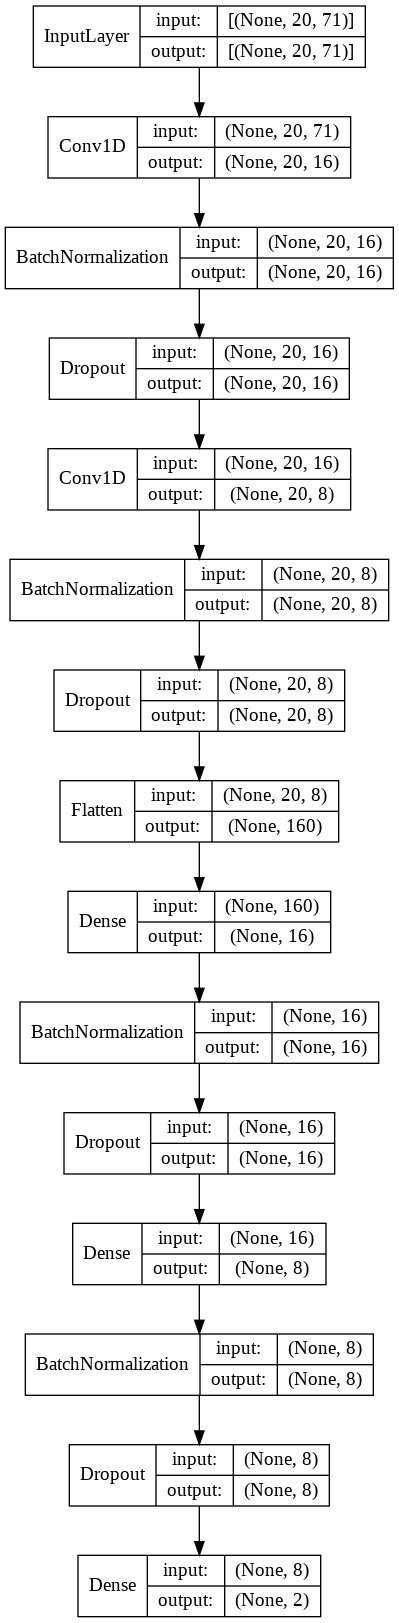

In [12]:
model = Network()
model.summary()
plot_model(model, to_file='model-single-Head-500-164.png', show_shapes=True, show_layer_names=False, expand_nested=True)

### [5]. Run Model:

Epoch 1/800
32/32 [==============================] - 4s 16ms/step - loss: 1.4468 - accuracy: 0.5320 - val_loss: 1.0686 - val_accuracy: 0.5122
Epoch 2/800
32/32 [==============================] - 0s 8ms/step - loss: 1.5235 - accuracy: 0.4740 - val_loss: 1.0864 - val_accuracy: 0.5122
Epoch 3/800
32/32 [==============================] - 0s 7ms/step - loss: 1.3371 - accuracy: 0.5080 - val_loss: 1.0982 - val_accuracy: 0.5183
Epoch 4/800
32/32 [==============================] - 0s 7ms/step - loss: 1.3145 - accuracy: 0.5320 - val_loss: 1.0966 - val_accuracy: 0.5122
Epoch 5/800
32/32 [==============================] - 0s 8ms/step - loss: 1.3357 - accuracy: 0.4880 - val_loss: 1.0916 - val_accuracy: 0.5000
Epoch 6/800
32/32 [==============================] - 0s 7ms/step - loss: 1.3529 - accuracy: 0.4940 - val_loss: 1.0778 - val_accuracy: 0.5061
Epoch 7/800
32/32 [==============================] - 0s 7ms/step - loss: 1.2728 - accuracy: 0.5300 - val_loss: 1.0691 - val_accuracy: 0.5061
Epoch 8/800


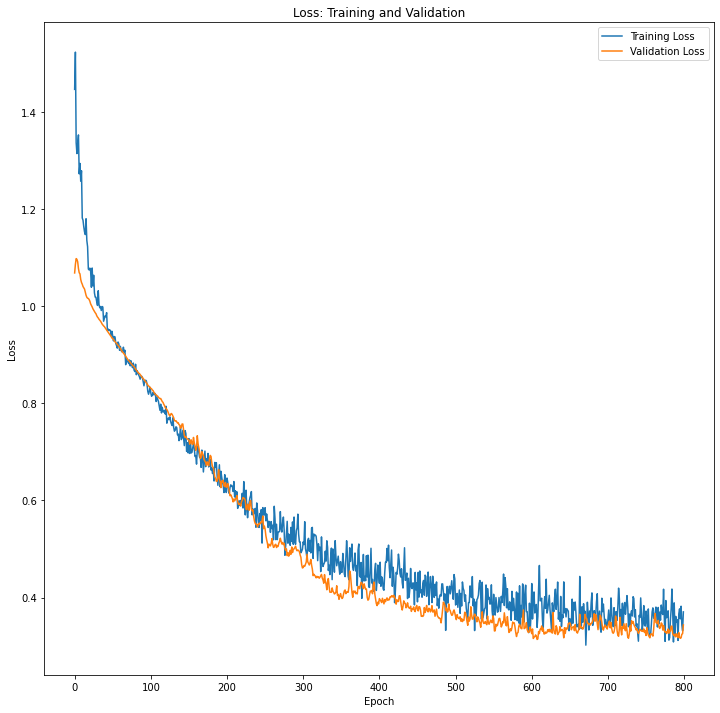

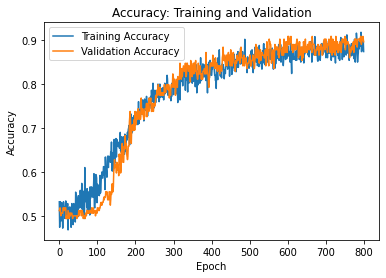

In [13]:
# Setting epoch and batch number
setEpochNumber     = 800       ### 2,500 performed well!
setBatchSizeNumber = 16


# ROC Curve:
fig1 = plt.figure(figsize=[12,12])
TPR = []
meanFPR = np.linspace(0, 1, 100)


# Compile Model:
model = Network()
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Run Model:
results = model.fit(x=Xtrain,
                    y=Ytrain,
                    validation_data=(Xtest, Ytest),
                    batch_size=setBatchSizeNumber, epochs=setEpochNumber,
                    verbose=1,
                    callbacks=[])
    

# Evaluate the Model:
accuracy = model.evaluate(x=Xtest, y=Ytest)

# Performance Metices:
Yactual = Ytest.argmax(axis=1)
Yp = model.predict(Xtest)
v = Yp
Yp = Yp.argmax(axis=1)

CM = confusion_matrix(y_pred=Yp, y_true=Yactual)
TN, FP, FN, TP = CM.ravel()

fpr, tpr, _ = roc_curve(Yactual, v[:,1])
AUC = auc(fpr, tpr)

print('Accuracy: {:.2f}'.format(accuracy[1]))
print('MCC: {:.2f}'.format(matthews_corrcoef(y_true=Yactual, y_pred=Yp)))
print('Sensitivity: {0:.4f}'.format(TP / (TP + FN)))
print('Specificity: {0:.4f}'.format(TN / (TN + FP)))
print('Precision: {0:.4f}'.format(precision_score(y_true=Yactual, y_pred=Yp)))
print('AUC: {0:.4f}'.format(AUC))

# # Performance Plot:
lossPlot(results)
accuracyPlot(results)

# # ROC Plot:
# fpr, tpr, _ = roc_curve(Yactual, v[:,1])
# TPR.append(interp(meanFPR, fpr, tpr))
# rocauc = auc(fpr, tpr)
# plt.plot(fpr, tpr, lw=2, alpha=1, label='ROC (AUC = %0.2f)' % (rocauc), color='blue')


# plt.plot([0,1], [0,1],linestyle = '--',lw = 2,color = 'black')

# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.title('Receiver Operating Characteristic Curve (ROC Curve)')
# plt.legend(loc="lower right")
# plt.savefig('ROC-500-164.png')
# plt.show()